In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\dwd_phenpy.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [4]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')
Maize_set.make_input_array()


project to new coords
interpolate driver to station locations


In [5]:
Maize_set.GDD_driver_data

<xarray.Dataset> Size: 281MB
Dimensions:             (time: 366, modelpoint: 31717)
Coordinates:
    time                (time, modelpoint) datetime64[ns] 93MB 1991-05-21T12:...
    lon                 (modelpoint) float64 254kB 9.433 9.433 ... 9.363 9.363
    lat                 (modelpoint) float64 254kB 54.78 54.78 ... 50.32 50.32
    x                   (modelpoint) float64 254kB 3.965e+06 ... 3.956e+06
    y                   (modelpoint) float64 254kB 3.1e+06 3.1e+06 ... 2.619e+06
  * modelpoint          (modelpoint) int32 127kB 0 1 2 3 ... 31714 31715 31716
Data variables:
    crs_HYRAS           int32 4B 1
    tas                 (time, modelpoint) float64 93MB 12.2 16.17 ... 1.337
    number_of_stations  (time, modelpoint) float64 93MB 1.605e+03 ... 1.456e+03
    emergence_dates     (modelpoint) datetime64[ns] 254kB 1991-05-21 ... 2022...
    Stations_id         (modelpoint) int64 254kB 7501 7501 7504 ... 19914 19914
    Referenzjahr        (modelpoint) int64 254kB 1991 1992 1999 ... 2019 2022
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

In [17]:
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set.dev_under_response(lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])
Maize_set.get_phase_dates(thresholds)
Maize_set.phase_list = ['beginning of flowering', 'yellow ripeness']
Maize_set.get_observed_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.get_modelled_dataset()#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.put_obs_data_in_input_array()
Maize_set.compare_modelled_observed()
Maize_set.get_X_y_for_ML('tas', cumulative=True, thinning_parameter=tp)
Maize_set.subsample_X_y(subsample_frac=0.8)
Maize_set.decision_tree(md=3)#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness'])#
Maize_set.ML_modelled_observed()

c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


array([[7.50100e+03, 5.47833e+01, 9.43330e+00],
       [7.50200e+03, 5.44000e+01, 1.01500e+01],
       [7.50400e+03, 5.43167e+01, 1.00500e+01],
       ...,
       [1.97580e+04, 5.06574e+01, 9.91350e+00],
       [1.97600e+04, 5.08619e+01, 1.12453e+01],
       [1.99140e+04, 5.03168e+01, 9.36270e+00]])

In [16]:
# data rows of csv file
coords = Maize_set.phen_data[['lat', 'lon', 'Stations_id']].drop_duplicates().values
# using the savetxt
# from the numpy module
np.savetxt("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\station_coords.csv",
        coords,
        delimiter =", ",
        fmt ='% s')

In [4]:
def RMSE_ML_model(ds, phases, training_means):
    def RMSE(residuals):
        return np.sqrt(np.mean(residuals**2))
    for phase_index, phase in enumerate(phases):
        print('Phase: ' + str(phase))
        ML_residuals = ds[f'ML prediction emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        ML_residuals = ML_residuals.where(np.abs(ML_residuals) < 60)
        model_residuals = ds[f'modelled time emergence to {phase}'] - ds[f'observed time emergence to {phase}']
        model_residuals = model_residuals.where(np.abs(model_residuals) < 60)
        residuals_to_average = training_means[phase_index] - ds[f'observed time emergence to {phase}']
        residuals_to_average = residuals_to_average.where(np.abs(model_residuals) < 60)
        print('RMSE for ML is ' + str(np.round(RMSE(ML_residuals), decimals=1)))
        print('RMSE for model is ' + str(np.round(RMSE(model_residuals), decimals=1)))
        print('RMSE to training mean is ' + str(np.round(RMSE(residuals_to_average), decimals=1)))

In [12]:
phase_list = ['beginning of flowering', 'yellow ripeness']
training_means = []
for phase in phase_list:
    training_means.append(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].mean())
    print(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==True)[f'observed time emergence to {phase}'].count())
RMSE_ML_model(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)
#plot_error_distn(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), phase_list, training_means)

9872
9872
Phase: beginning of flowering
RMSE for ML is 10.2
RMSE for model is 14.2
RMSE to training mean is 10.2
Phase: yellow ripeness
RMSE for ML is 15.3
RMSE for model is 27.5
RMSE to training mean is 13.7


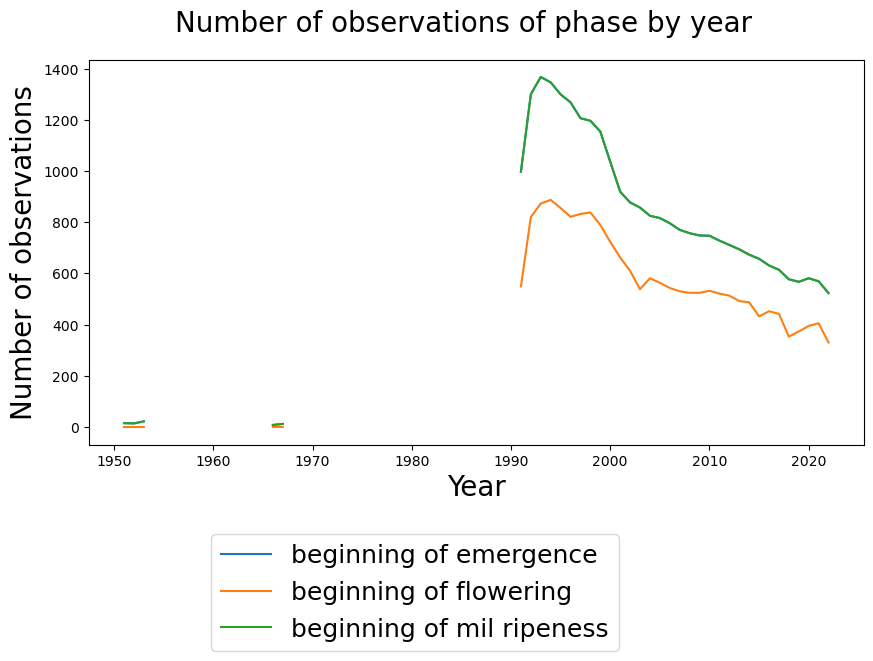

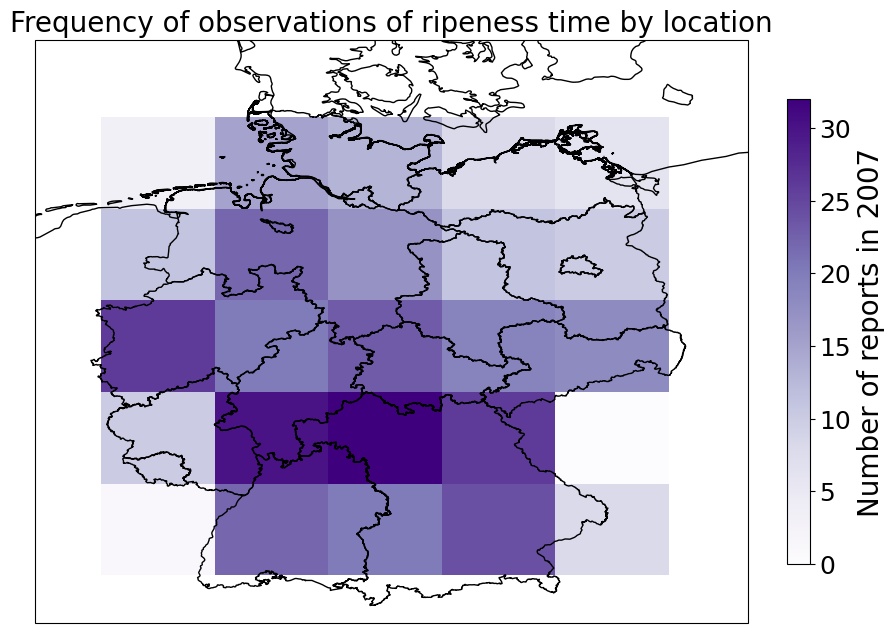

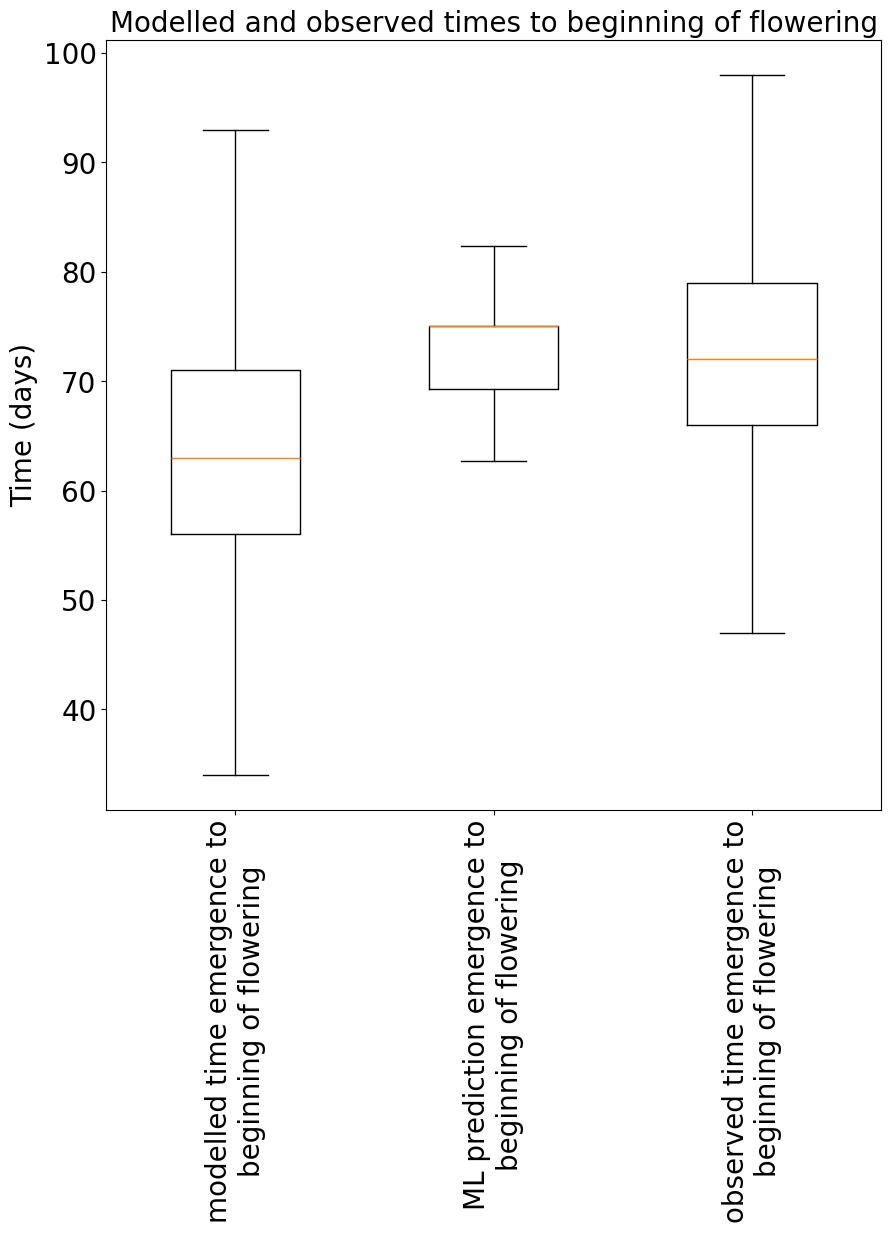

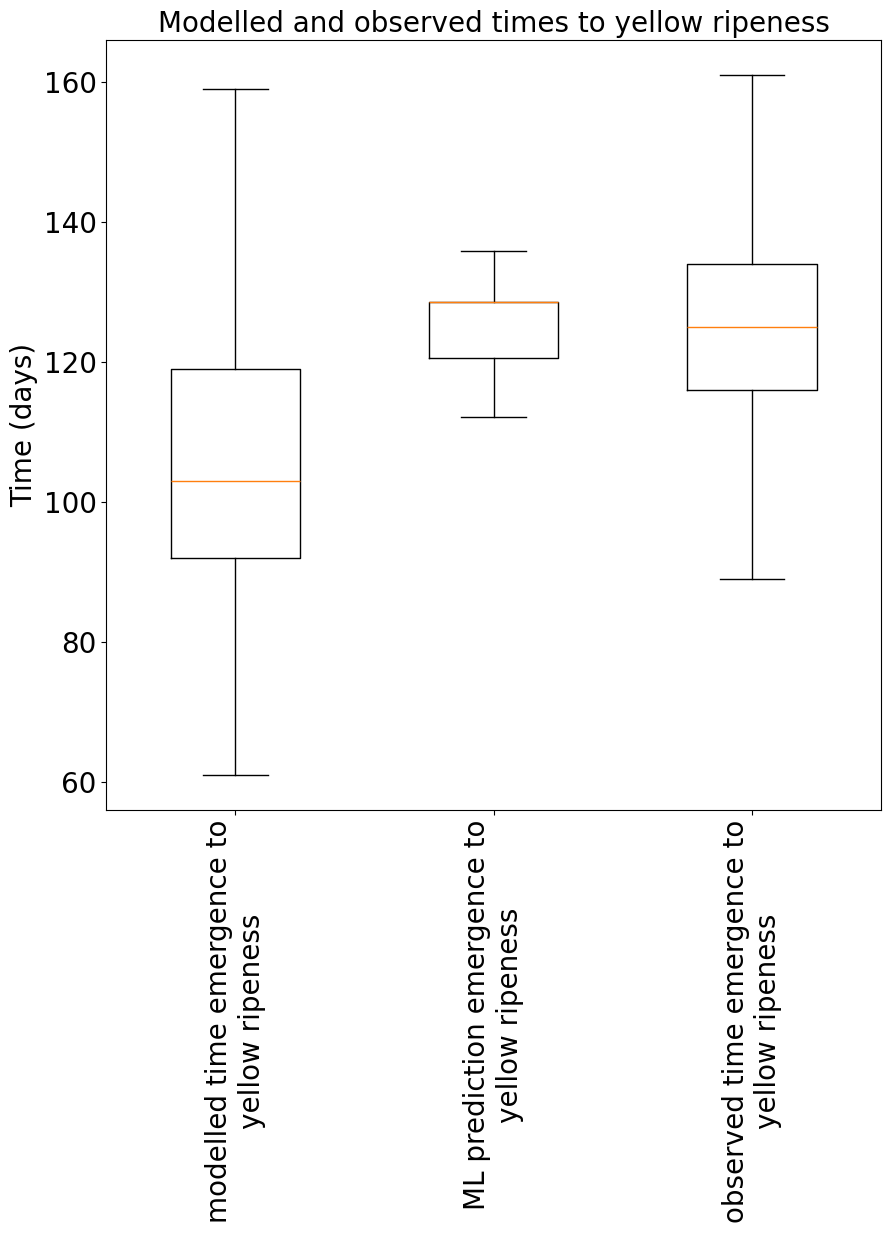

In [4]:
phase_list = ['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness']#['beginning of emergence', 'beginning of flowering', 'beginning of mil ripeness', 'harvest']
#Maize_set.get_observed_dataset(phase_list=phase_list)
plotting.plot_obs_per_year(Maize_set.ds_observed, 'obs_per_year', phase_list=phase_list)
plotting.hist2d_locations(Maize_set.ds_observed.loc[2020].dropna()['lat'], Maize_set.ds_observed.loc[2020].dropna()['lon'], bin_num=5)
plotting.box_plot_modelled_observed(Maize_set.ds_ML_modelled_observed.where(Maize_set.ds_ML_modelled_observed['Training'] ==False), ['beginning of flowering', 'yellow ripeness'])

In [18]:
tree_rules = tree.export_text(Maize_set.regr, feature_names=[f'Day {tp*i} cum. temp' for i in range(np.int64(np.floor(200/tp)))])
print(Maize_set.y_for_ML)
print(tree_rules)

ValueError: feature_names must contain 67 elements, got 66

In [2]:
class Phenology_set:

    phase_names = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phase.txt", encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

    def __init__(self, address):
        self.phen_data = pd.read_csv(address, encoding = "latin1", engine='python', sep = r';\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;')
        ## CONVERT DATE TO DATETIME ##
        self.phen_data['Eintrittsdatum'] = pd.to_datetime(self.phen_data['Eintrittsdatum'], format = '%Y%m%d')
        self.phen_data = self.phen_data.drop(self.phen_data[self.phen_data['Qualitaetsniveau'] != 10].index)
        self.phase_list = [] #list of phases to consider
        self.add_locations()
        #print(self.phen_data['Qualitaetsniveau'].values)
        self.T_mean = ''
        self.GDD_driver_data = ''
        self.ordered = False

    ### Functions for sorting out dataset ###
    def drop_columns(self, drop_list):
        for drop_name in drop_list:
            self.phen_data = self.phen_data.drop(drop_name, axis = 1)
    
    def phase_order_name(self, stage_order): #[10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ]
        self.phen_data['Order of phase'] = np.nan
        self.phen_data['Name of phase'] = ''
        for i, phaseid in enumerate(stage_order):
            if len(self.phase_names['Phase_englisch'][self.phase_names['Phase_ID'] == str(phaseid)]) != 0:
                #print(i, phaseid)
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Order of phase'] = i
                self.phen_data.loc[self.phen_data['Phase_id'] == phaseid, 'Name of phase'] = dataset_fctns.get_phase_name(phaseid, self.phase_names)
        self.order_phen_dataset()

    def order_phen_dataset(self):
        ## SORT BY TIME ##
        if not(np.isin('Order of phase', self.phen_data.columns)):
            print('Get phase order and names first')
        else:
            self.phen_data.sort_values(by = ['Stations_id', 'Referenzjahr', 'Eintrittsdatum', 'Order of phase'])
            self.ordered = True
    
    def get_time_to_next_stage(self):
        #Note phen_data must be time and station ordered. Only plots time to next stage - naive as doesn't consider missing phases.
        if self.ordered:
            ## CALCULATE TIME TO NEXT STAGE ##
            self.phen_data['Time to next stage'] = self.phen_data['Eintrittsdatum'].shift(-1) - self.phen_data['Eintrittsdatum']
            self.phen_data['Next stage name'] = self.phen_data['Name of phase'].shift(-1)
            ## EXCLUDE CHANGES IN STATION ##
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Time to next stage'] = np.nan
            self.phen_data.loc[self.phen_data['Stations_id'] != self.phen_data['Stations_id'].shift(-1), 'Next stage name'] = np.nan
        else:
            print('Order dataset so I can get time to next stage')

    def add_locations(self):
        self.phen_data = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #LAT, LON = dataset_fctns.get_station_locations(self.phen_data, self.station_data)
        #self.phen_data['lat'] = LAT
        #self.phen_data['lon'] = LON
        #self.phen_data['lat'] = self.phen_data['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.phen_data['lon'] = self.phen_data['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    ### Functions for applying GDD model ###
    def get_mean_T(self, T_address):
        self.T_mean = xr.open_dataset(T_address)

    def index_time_from_emergence_day(self):
        i_day = self.GDD_driver_data['emergence_dates'].values.copy()
        i_daysofyear = np.array([i_day + np.timedelta64(12, 'h') + np.timedelta64(day_of_year, 'D') for day_of_year in range(366)])
        time_indexer = xr.DataArray(i_daysofyear, dims=[ "time", 'modelpoint'])
        self.GDD_driver_data = self.GDD_driver_data.sel(time=time_indexer, method='nearest')

    def make_input_array(self):
        ## Puts pandas phenological frame into driver xarray and aligns the two
        just_emergence_phen_data = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
        ## For now just do data after 2005 to save time
        just_emergence_phen_data = just_emergence_phen_data.where(just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('1991-01-01')).dropna()
        x_coords = just_emergence_phen_data['lon'].values
        y_coords = just_emergence_phen_data['lat'].values
        #Makes an array to put into GDD model
        print('project to new coords')
        x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_coords, y_coords)
        print('interpolate driver to station locations')
        # Working in xarray (not pandas) after this point:
        self.GDD_driver_data = dataset_fctns.interpolate_xy(x_epsg, y_epsg, self.T_mean)
        self.GDD_driver_data['emergence_dates'] = (("modelpoint"), just_emergence_phen_data['Eintrittsdatum'].values)
        self.GDD_driver_data['Stations_id'] = (("modelpoint"), np.int64(just_emergence_phen_data['Stations_id'].values))
        self.GDD_driver_data['Referenzjahr'] = (("modelpoint"), np.int64(just_emergence_phen_data['Referenzjahr'].values))
        self.GDD_driver_data = self.GDD_driver_data.assign_coords(modelpoint=np.arange(self.GDD_driver_data.sizes['modelpoint']))
        ## Get times to be indexed from emergence day start at emergence day for every site ##
        self.index_time_from_emergence_day()
        self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
        
    
    def dev_under_response(self, response, driver_variable, maturity_t_dev):
        # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
        if type(self.GDD_driver_data) == str:
            print('Make a dataset for the driving variable first')
        else:
            t_dev = np.zeros(self.GDD_driver_data[driver_variable].isel(time=0).values.shape) #Continuous development time. When this passes through some thresholds then have change in phase.
            dev_time_series = [t_dev.copy()]
            for day in range(365):
                driver_values = self.GDD_driver_data.isel(time=day)[driver_variable].values 
                t_dev += response(driver_values, t_dev)
                dev_time_series.append(t_dev.copy())
            self.model_dev_time_series = np.array(dev_time_series)
            self.GDD_driver_data['Development Time'] = (('days from emergence', 'modelpoint'), self.model_dev_time_series)

    def get_phase_dates(self, thresholds):
        self.phase_dates_array = np.zeros((len(thresholds), self.model_dev_time_series.shape[1]))
        for obs_index in range(self.model_dev_time_series.shape[1]):
            self.phase_dates_array[:, obs_index] = np.digitize(thresholds, self.model_dev_time_series[:, obs_index]) #Note that the thresholds are NOT the bins for numpy digitize!
    
    def get_modelled_dataset(self):
        if len(self.phase_list) == 0:
            computed_phases = [f'modelled time emergence to phase {i + 1}' for i in range(self.phase_dates_array.shape[0])]
        else:
            computed_phases = [f'modelled time emergence to {phase}' for phase in self.phase_list]
            #Initialize dataset for comparison with station IDs and years
        data_comparison = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values),
                        }
        self.ds_comparison = pd.DataFrame(data_comparison)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(computed_phases):
            self.ds_comparison[phase] = self.phase_dates_array[phase_index, :]
        self.ds_comparison.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    ## Functions for evaluation ##
    def get_observed_dataset(self, winter_sowing = False):
        observed_to_first_stage = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', self.phase_list[0], winter_sowing=winter_sowing).dropna()
        self.ds_observed = pd.DataFrame({f'observed time emergence to {self.phase_list[0]}': observed_to_first_stage})
        for phase in self.phase_list[1:]:
            self.ds_observed[f'observed time emergence to {phase}'] = dataset_fctns.time_stage_to_stage(self.phen_data, 'beginning of emergence', phase, winter_sowing=winter_sowing).dropna()
        self.ds_observed = self.ds_observed.reset_index()
        self.ds_observed = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        self.ds_observed = self.ds_observed.set_index(['Referenzjahr', 'Stations_id'])
        #LAT, LON = dataset_fctns.get_station_locations(self.ds_observed, self.station_data)
        #self.ds_observed['lat'] = LAT
        #self.ds_observed['lon'] = LON
        #self.ds_observed['lat'] = self.ds_observed['lat'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
        #self.ds_observed['lon'] = self.ds_observed['lon'].map(lambda x: x[0] if isinstance(x, np.float64) == False else x)
    
    def compare_modelled_observed(self):
        self.ds_modelled_observed = pd.concat([self.ds_comparison, self.ds_observed], axis = 1)

    ## Functions for ML ##    
    def put_obs_data_in_input_array(self): #, predictor_days = 200
        y_data = {}
        for phase_time in self.ds_observed.columns:
            if phase_time != 'lat' and phase_time != 'lon':
                y_data[phase_time] = (['modelpoint'], self.ds_observed[phase_time].values)
        #print(y_data)
        obs_data = xr.Dataset(data_vars = y_data,
                                coords = {'Referenzjahr':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(0))),
                                        'Stations_id':(['modelpoint'], np.int64(self.ds_observed.index.get_level_values(1)))}
                                        )
        #print(obs_data)
        obs_data = obs_data.set_xindex(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = self.GDD_driver_data.reset_index('modelpoint')
        #self.GDD_driver_data['Stations_id'] = self.GDD_driver_data['Stations_id'].astype(np.int64)
        #self.GDD_driver_data['Referenzjahr'] = self.GDD_driver_data['Referenzjahr'].astype(np.int64)
        self.GDD_driver_data = self.GDD_driver_data.set_coords(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_coords(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = self.GDD_driver_data.set_xindex(['Referenzjahr', 'Stations_id']) #self.data_for_ML = self.data_for_ML.set_xindex(['Referenzjahr', 'Stations_id'])
        self.GDD_driver_data = xr.merge([self.GDD_driver_data, obs_data], join='left') #self.data_for_ML = xr.merge([self.data_for_ML, obs_data], join='left')#[driver_variable]
        self.GDD_driver_data = self.GDD_driver_data.dropna('modelpoint') #self.data_for_ML = self.data_for_ML.dropna('modelpoint')
        
    def get_X_y_for_ML(self, driver_variable, predictor_days = 200, cumulative = False, thinning_parameter = 1):
        self.X_for_ML = self.GDD_driver_data[driver_variable][:predictor_days, :].values.T
        if cumulative:
            self.X_for_ML = np.cumsum(self.X_for_ML, axis=1)
        if thinning_parameter != 1:
            self.X_for_ML = self.X_for_ML[:, ::thinning_parameter]
        self.y_for_ML = np.array([self.GDD_driver_data[phase_time].values for phase_time in self.ds_observed.columns[:-2]])[:predictor_days, :].T
    
    def subsample_X_y(self, subsample_frac = 0.5):
        self.subsample = np.random.choice(np.arange(self.y_for_ML.shape[0]),np.int64(np.floor(self.y_for_ML.shape[0]*subsample_frac)))
        self.training_X = self.X_for_ML[self.subsample, :]
        self.training_y = self.y_for_ML[self.subsample, :]
        self.complement_of_subsample = np.delete(np.arange(self.y_for_ML.shape[0]), self.subsample)
        self.verification_X = self.X_for_ML[self.complement_of_subsample, :]
        self.verification_y = self.y_for_ML[self.complement_of_subsample, :]

        self.training_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.subsample]
        self.training_stationid = self.GDD_driver_data['Stations_id'].values[self.subsample]
        self.verification_referenzjahr = self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]
        self.verification_stationid = self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]
    
    def decision_tree(self, md=20):
        self.regr = tree.DecisionTreeRegressor(max_depth=md, min_samples_leaf=5)
        self.fit = self.regr.fit(self.training_X, self.training_y)
        data_ML_training = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.subsample]),
                        'Training': np.array([True for count in range(len(self.subsample))])
                        }
        data_ML_verification = {'Stations_id': np.int64(self.GDD_driver_data['Stations_id'].values[self.complement_of_subsample]),
                        'Referenzjahr': np.int64(self.GDD_driver_data['Referenzjahr'].values[self.complement_of_subsample]),
                        'Training': np.array([False for count in range(len(self.complement_of_subsample))])
                        }
        self.ds_ML_predictions_training = pd.DataFrame(data_ML_training)
        self.ds_ML_predictions_verification = pd.DataFrame(data_ML_verification)
        #Add modelled phase dates etc. to the comparison set.
        for phase_index, phase in enumerate(self.phase_list):
            self.ds_ML_predictions_training[f'ML prediction emergence to {phase}'] = self.fit.predict(self.training_X)[:, phase_index]
            self.ds_ML_predictions_verification[f'ML prediction emergence to {phase}'] = self.fit.predict(self.verification_X)[:, phase_index]
            self.ds_ML_predictions_training[f'ML check obs to {phase}'] = self.training_y[:, phase_index]
            self.ds_ML_predictions_verification[f'ML check obs to {phase}'] = self.verification_y[:, phase_index]
        self.ds_ML_predictions_training = self.ds_ML_predictions_training.drop_duplicates()
        self.ds_ML_predictions_verification = self.ds_ML_predictions_verification.drop_duplicates()
        self.ds_ML_results = pd.concat([self.ds_ML_predictions_verification, self.ds_ML_predictions_training], axis=0)
        self.ds_ML_results.set_index(['Referenzjahr', 'Stations_id'], inplace=True)
    
    def ML_modelled_observed(self):
        self.ds_ML_modelled_observed = pd.concat([self.ds_ML_results, self.ds_comparison, self.ds_observed], axis = 1)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_3084\3939393862.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [26]:
Maize_set.just_emergence_phen_data = Maize_set.just_emergence_phen_data.where(Maize_set.just_emergence_phen_data['Referenzjahr'] <= 2020)
time_station = xr.Dataset.from_dataframe(Maize_set.just_emergence_phen_data[['Stations_id', 'Eintrittsdatum']])
time_station = time_station.rename({'index':'Emergence observation', 'Eintrittsdatum':'time'})
time_station['time'] += np.timedelta64(12, 'h')
time_station = time_station.where(np.isin(time_station['time'], Maize_set.GDD_driver_data['time']))
time_station = time_station.where(np.isin(time_station['Stations_id'], Maize_set.GDD_driver_data['Stations_id']))
time_station = time_station.dropna(dim='Emergence observation')
driver_values = self.GDD_driver_data.sel(time_station)
#Maize_set.GDD_driver_data = Maize_set.GDD_driver_data.rename({'modelpoint':'Stations_id'}).set_index(Stations_id='Stations_id')
#time_station_indexer = xr.DataArray(time_station, dims=['modelpoint'])

In [45]:
self = Maize_set

In [47]:
self.just_emergence_phen_data = self.just_emergence_phen_data.where(self.just_emergence_phen_data['Referenzjahr'] <= 2020)
time_station = xr.Dataset.from_dataframe(self.just_emergence_phen_data[['Stations_id', 'Eintrittsdatum']])
time_station = time_station.rename({'index':'Emergence observation', 'Eintrittsdatum':'time'})
time_station['time'] += np.timedelta64(12, 'h')
time_station = time_station.where(np.isin(time_station['time'], Maize_set.GDD_driver_data['time']))
time_station = time_station.where(np.isin(time_station['Stations_id'], Maize_set.GDD_driver_data['Stations_id']))
time_station = time_station.dropna(dim='Emergence observation')
t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
dev_time_series = [t_dev.copy()]
for day in range(365):
    driver_values = self.GDD_driver_data.sel(time_station)['tas'].values 
    t_dev += response(driver_values, t_dev)
    dev_time_series.append(t_dev.copy())
    time_station['time'] += np.timedelta64(1, 'D')
self.model_dev_time_series = np.array(dev_time_series)
self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6612\4247065754.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.


NameError: name 'response' is not defined

In [50]:
def dev_under_response(self, response, driver_variable, maturity_t_dev):
    # Response is the rate response to driver values. Driver values are the input to this response. Maturity_t_dev is the t_dev value where we should stop running.
    if type(self.GDD_driver_data) == str:
        print('Make a dataset for the driving variable first')
    else:
        self.just_emergence_phen_data = self.just_emergence_phen_data.where(self.just_emergence_phen_data['Referenzjahr'] <= 2019)
        time_station = xr.Dataset.from_dataframe(self.just_emergence_phen_data[['Stations_id', 'Eintrittsdatum']])
        time_station = time_station.rename({'index':'Emergence observation', 'Eintrittsdatum':'time'})
        time_station['time'] += np.timedelta64(12, 'h')
        time_station = time_station.where(np.isin(time_station['time'], Maize_set.GDD_driver_data['time']))
        time_station = time_station.where(np.isin(time_station['Stations_id'], Maize_set.GDD_driver_data['Stations_id']))
        time_station = time_station.dropna(dim='Emergence observation')
        t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
        dev_time_series = [t_dev.copy()]
        for day in range(365):
            print(day)
            driver_values = self.GDD_driver_data.sel(time_station)[driver_variable].values 
            t_dev += response(driver_values, t_dev)
            dev_time_series.append(t_dev.copy())
            time_station['time'] += np.timedelta64(1, 'D')
        self.model_dev_time_series = np.array(dev_time_series)
        self.GDD_driver_data['Development Time'] = (('days from emergence', 'Emergence observation'), self.model_dev_time_series)

In [51]:
tp=3
resps = [lambda x: 0.053*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36), lambda x: 0.055*modelling_fctns.Wang_Engel_Temp_response(x, 8, 28, 36)]
#[lambda x: 0.0254*modelling_fctns.Wang_Engel_Temp_response(x, 0, 27.5, 40), lambda x: 0.0289*modelling_fctns.Wang_Engel_Temp_response(x, 0, 33, 44)]#0.0254, 0.0289
thresholds = [1, 2]
Maize_set = dev_under_response(Maize_set, lambda x, y: modelling_fctns.phase_dependent_response(x, y, resps, thresholds), 
                             'tas', thresholds[-1])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6612\2054536639.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  t_dev = np.zeros(time_station.dims['Emergence observation']) #Continuous development time. When this passes through some thresholds then have change in phase.
c:\Users\wlwc1989\Documents\Phenology_Test_Notebooks\phenology_dwd\modelling_fctns.py:16: RuntimeWarning: invalid value encountered in power
  f_T = ( ( (2*(T - T_min)**alpha)*((T_opt - T_min)**alpha) - ((T - T_min)**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [2]:
def make_input_array(self):
    ## Puts pandas phenological frame into driver xarray and aligns the two
    self.just_emergence_phen_data = self.phen_data.where(self.phen_data['Name of phase'] == 'beginning of emergence').dropna()
    ## For now just do data after 2005 to save time
    self.just_emergence_phen_data = self.just_emergence_phen_data.where(self.just_emergence_phen_data['Eintrittsdatum'] > np.datetime64('2007-01-01')).dropna()
    x_coords = self.just_emergence_phen_data['lon'].values
    y_coords = self.just_emergence_phen_data['lat'].values
    station_ids = np.int64(self.just_emergence_phen_data['Stations_id'].values)
    x_unique, y_unique, stations = get_unique_xy_station(x_coords, y_coords, station_ids)
    
    #Makes an array to put into GDD model
    print('project to new coords')
    x_epsg, y_epsg = dataset_fctns.latlon_to_projection(x_unique, y_unique)
    print('interpolate driver to station locations')
    # Working in xarray (not pandas) after this point:
    self.GDD_driver_data = dataset_fctns.interpolate_xy(x_epsg, y_epsg, self.T_mean)
    self.GDD_driver_data = self.GDD_driver_data.assign_coords(Stations_id=("modelpoint", stations))
    self.GDD_driver_data = self.GDD_driver_data.drop_dims('bnds')
    #self.GDD_driver_data['emergence_dates'] = (("modelpoint"), just_emergence_phen_data['Eintrittsdatum'].values)
    #self.GDD_driver_data['Stations_id'] = (("modelpoint"), np.int64(just_emergence_phen_data['Stations_id'].values))
    #self.GDD_driver_data['Referenzjahr'] = (("modelpoint"), np.int64(just_emergence_phen_data['Referenzjahr'].values))
    #self.GDD_driver_data = self.GDD_driver_data.assign_coords(modelpoint=np.arange(self.GDD_driver_data.sizes['modelpoint']))
    ## Get times to be indexed from emergence day start at emergence day for every site ##
    #self.index_time_from_emergence_day()
    return self

In [3]:
def get_unique_xy_station(x_coords, y_coords, station_ids):
    unique_values = np.unique(np.stack([x_coords, y_coords, station_ids]), axis = 1)
    return unique_values[0, :], unique_values[1, :], unique_values[2, :]

In [4]:
Maize_set = Phenology_set("C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\PH_Jahresmelder_Landwirtschaft_Kulturpflanze_Mais_1936_2023_hist.txt")
Maize_set.drop_columns(['Unnamed: 9'])
Maize_set.phase_order_name([10, 12, 67, 65, 5, 6, 19, 20, 21, 24, ])
Maize_set.get_mean_T('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc')

In [5]:
Maize_set = make_input_array(Maize_set)

project to new coords
interpolate driver to station locations


In [9]:
X.GDD_driver_data

<xarray.Dataset> Size: 260MB
Dimensions:             (time: 25568, bnds: 2, modelpoint: 1268)
Coordinates:
  * time                (time) datetime64[ns] 205kB 1951-01-01T12:00:00 ... 2...
    lon                 (modelpoint) float64 10kB 6.017 6.024 ... 14.95 15.03
    lat                 (modelpoint) float64 10kB 51.78 50.8 ... 51.03 51.27
    x                   (modelpoint) float64 10kB 3.735e+06 ... 4.339e+06
    y                   (modelpoint) float64 10kB 2.784e+06 ... 2.733e+06
    Stations_id         (modelpoint) float64 10kB 8.776e+03 ... 1.288e+04
Dimensions without coordinates: bnds, modelpoint
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 409kB 1951-01-01 ... 2021...
    x_bnds              (modelpoint, bnds) float64 20kB 3.732e+06 ... 4.341e+06
    y_bnds              (modelpoint, bnds) float64 20kB 2.781e+06 ... 2.735e+06
    crs_HYRAS           int32 4B 1
    tas                 (time, modelpoint) float64 259MB nan nan nan ... nan nan
    number_of_stations  (time) float64 205kB 817.0 818.0 ... 1.454e+03 1.456e+03
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8